In [49]:
import pandas as pd
from glob import glob
import json
import matplotlib.pyplot as plt
import matplotlib as mpl
import rdflib
import re
from tqdm import tqdm
import numpy as np

## Analyse training

In [50]:
files = glob("analysis/results/*.json")
df = None

for f in files:
  f_data = json.load(open(f))
  series = pd.Series()

  model, degree, _, _ = f.split(".")
  degree = ''.join([char for char in degree if char.isdigit()])
  series["degree"] = int(degree) + 1
  series["model"] = model

  #series["train_losses"] = f_data["train_losses"]
  #series["train_loss"] = f_data["train_losses"][-1] if len(series["train_losses"]) > 0 else -1

  #series["test_losses"] = f_data["test_losses"]
  #series["test_loss"] = f_data["test_losses"][-1] if len(series["test_losses"]) > 0 else -1

  for rel, val in f_data["relationship_weights"].items():
    series[rel] = val


  metrics = {k: [m[k] for m in f_data["metrics"]] for k in f_data["metrics"][0].keys()}
  #series["metrics"] = metrics

  for k, v in metrics.items():
    series[k] = max(v) #[-1]

  series = series.to_frame().T
  if df is None:
    df = series
  else:
    df = pd.concat([df, series])

df.columns = [c.replace("@None", "") for c in df.columns]

In [51]:
x_labels = ["Learned", "freq", "freq$^{-1}$", 1]
df_model = ['analysis/results/fit', 'analysis/results/frequency', 'analysis/results/inverse-frequency', 'analysis/results/uniform']

In [52]:
df

,degree,model,http://w3id.org/friendshipneverends/ontology/predecessor20Years,http://w3id.org/friendshipneverends/ontology/sameplaceofbirth,http://w3id.org/friendshipneverends/ontology/hasBandmate,http://w3id.org/friendshipneverends/ontology/teenagersInTheSameDecade,http://w3id.org/friendshipneverends/ontology/hasAcquaintance,http://w3id.org/friendshipneverends/ontology/predecessor10Years,http://w3id.org/friendshipneverends/ontology/samerecordlabel,http://w3id.org/friendshipneverends/ontology/hasPupil,...,MAP@20,DCG@20,H@50,MRR@50,MAP@50,DCG@50,H@100,MRR@100,MAP@100,DCG@100
0,3,analysis/results/frequency,0.002757,0.017518,0.000568,0.120962,0.004392,0.006991,0.029899,0.000122,...,0.029295,0.017782,0.466667,0.035903,0.029277,0.054438,0.533333,0.036913,0.027878,0.073953
0,2,analysis/results/frequency,0.002757,0.017518,0.000568,0.120962,0.004392,0.006991,0.029899,0.000122,...,0.181249,0.091669,0.6,0.179264,0.125522,0.141529,0.8,0.182799,0.091979,0.181967
0,5,analysis/results/inverse-frequency,362.695612,57.082586,1761.664399,8.267028,227.694607,143.034889,33.446444,8221.100529,...,0.098022,0.072749,0.8,0.132988,0.081082,0.145715,0.866667,0.134137,0.076544,0.192994
0,2,analysis/results/frequency,0.002757,0.017518,0.000568,0.120962,0.004392,0.006991,0.029899,0.000122,...,0.155826,0.115207,0.6,0.159802,0.100378,0.164631,0.733333,0.161795,0.097303,0.189098
0,2,analysis/results/fit,0.133431,0.185288,0.162069,0.138955,-1.587531,0.184403,0.169291,0.170445,...,0.529128,0.472049,1.0,0.586019,0.444594,0.519557,1.0,0.586019,0.397921,0.555093
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,3,analysis/results/uniform,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.04213,0.020164,0.666667,0.055696,0.044343,0.096742,0.8,0.057204,0.044884,0.116449
0,2,analysis/results/uniform,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.436163,0.368872,1.0,0.57963,0.38337,0.435236,1.0,0.57963,0.327034,0.47517
0,3,analysis/results/inverse-frequency,362.695612,57.082586,1761.664399,8.267028,227.694607,143.034889,33.446444,8221.100529,...,0.030175,0.020048,0.6,0.04416,0.045949,0.074876,0.733333,0.04617,0.050634,0.12598
0,3,analysis/results/frequency,0.002757,0.017518,0.000568,0.120962,0.004392,0.006991,0.029899,0.000122,...,0.131879,0.115278,0.733333,0.150845,0.12647,0.145228,0.8,0.151856,0.120075,0.179135


<>:13: SyntaxWarning: invalid escape sequence '\m'
<>:13: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_6378/2609422021.py:13: SyntaxWarning: invalid escape sequence '\m'
  ax[idx].set_xlabel(f"$\mu({measure})$")


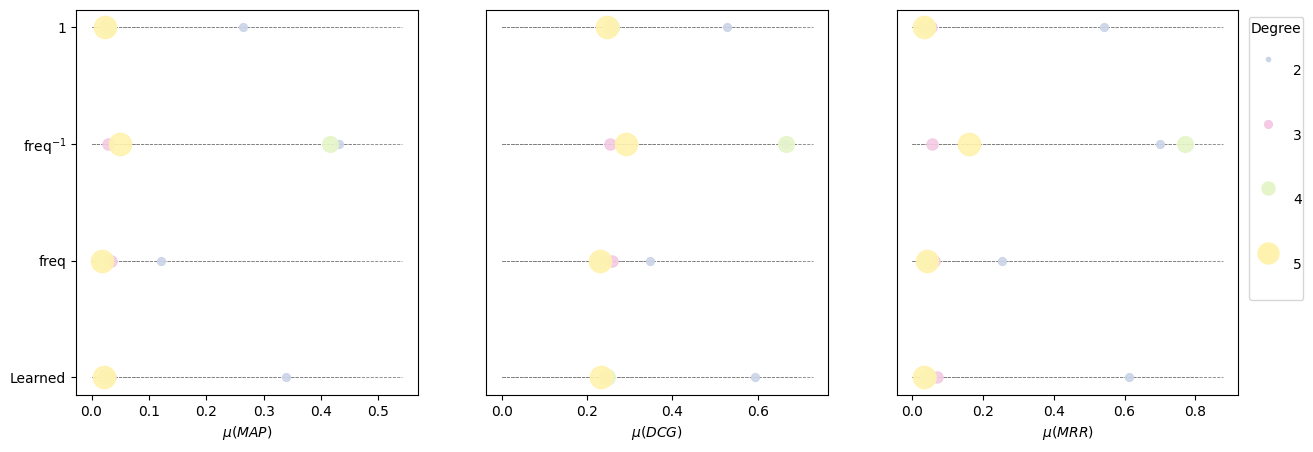

In [53]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
cmap = mpl.colormaps["Pastel2"]
x_axis = list(range(len(x_labels)))
degrees = sorted(df.degree.unique())

for model, x in zip(df_model, x_axis):
  model_df = df[df.model == model]
  for degree in degrees:
    for idx, measure in enumerate(["MAP", "DCG", "MRR"]):
      val = model_df[model_df.degree == degree][measure].mean()
      ax[idx].hlines(x, 0, df[df.degree == degree][measure].max(), colors="grey", linestyles="dashed", zorder=-1, linewidths=0.6)
      ax[idx].scatter(val, x, color=cmap(degree), s=2 ** (degree + 3), alpha=0.9)
      ax[idx].set_xlabel(f"$\mu({measure})$")

      if idx == 0:
        ax[idx].set_yticks(x_axis, x_labels)
      else:
        ax[idx].set_yticks([])

legend_elements = [
  mpl.lines.Line2D([0], [0], marker='o', color='w', label=degree, markerfacecolor=cmap(degree), markersize=1.5 ** (degree + 2))
  for degree in degrees
]
ax[-1].legend(handles=legend_elements, bbox_to_anchor=(1.01, 1, 0.2, 0), loc='upper left', mode="expand", title="Degree", handleheight=6)

fig.savefig('figures/degree_performance.png', dpi=300, bbox_inches="tight")

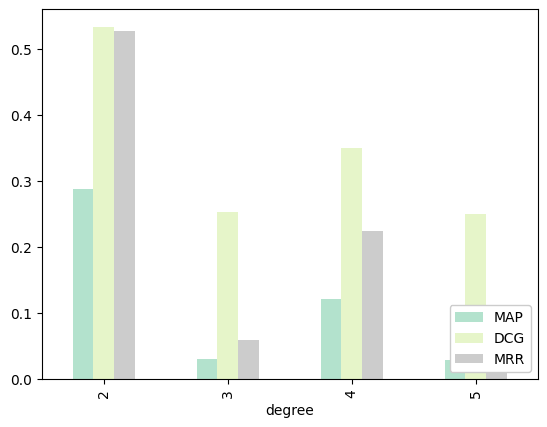

In [54]:
ax = df.groupby(["degree"])[["MAP", "DCG", "MRR"]].mean().plot.bar(cmap="Pastel2")
ax.legend(loc='lower right', framealpha=1)
fig = ax.get_figure()
fig.savefig('figures/degree_plot.png', dpi=300, bbox_inches="tight")

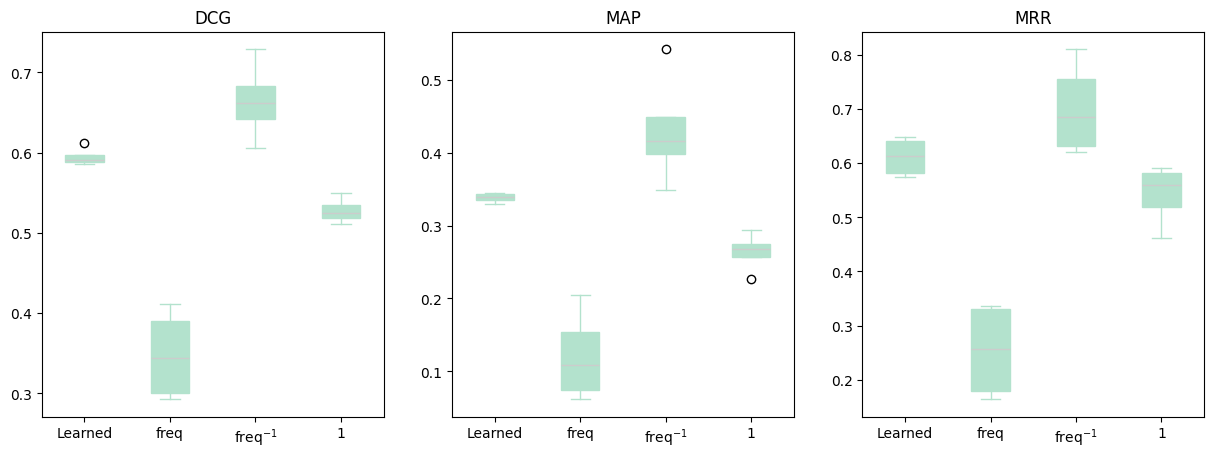

In [55]:
axs = df[df.degree == 2].plot.box(column=["MAP", "DCG", "MRR"], cmap="Pastel2", by="model", figsize=(15, 5), patch_artist=True)

for ax in axs:
  ax.set_xticklabels(["Learned", "freq", "freq$^{-1}$", 1])

fig.savefig('figures/degree_plot.png', dpi=300, bbox_inches="tight")

In [56]:
print(df[df.degree == 2].sort_values(["MAP", "DCG", "MRR"], ascending=False).groupby("model")[["MAP", "DCG", "MRR"]].agg(lambda x: f"${x.mean():1.2f} \pm {x.std():1.2f}$").to_latex())

\begin{tabular}{llll}
\toprule
 & MAP & DCG & MRR \\
model &  &  &  \\
\midrule
analysis/results/fit & $0.34 \pm 0.01$ & $0.59 \pm 0.01$ & $0.61 \pm 0.04$ \\
analysis/results/frequency & $0.12 \pm 0.06$ & $0.35 \pm 0.06$ & $0.25 \pm 0.09$ \\
analysis/results/inverse-frequency & $0.43 \pm 0.08$ & $0.66 \pm 0.05$ & $0.70 \pm 0.09$ \\
analysis/results/uniform & $0.26 \pm 0.03$ & $0.53 \pm 0.02$ & $0.54 \pm 0.06$ \\
\bottomrule
\end{tabular}



<>:1: SyntaxWarning: invalid escape sequence '\p'
<>:1: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_6378/1830718600.py:1: SyntaxWarning: invalid escape sequence '\p'
  print(df[df.degree == 2].sort_values(["MAP", "DCG", "MRR"], ascending=False).groupby("model")[["MAP", "DCG", "MRR"]].agg(lambda x: f"${x.mean():1.2f} \pm {x.std():1.2f}$").to_latex())


In [57]:
columns = [
  'http://w3id.org/friendshipneverends/ontology/predecessor20Years','http://w3id.org/friendshipneverends/ontology/sameplaceofbirth',
  'http://w3id.org/friendshipneverends/ontology/hasBandmate','http://w3id.org/friendshipneverends/ontology/teenagersInTheSameDecade',
  'http://w3id.org/friendshipneverends/ontology/hasAcquaintance','http://w3id.org/friendshipneverends/ontology/predecessor10Years',
  'http://w3id.org/friendshipneverends/ontology/samerecordlabel','http://w3id.org/friendshipneverends/ontology/hasPupil',
  'http://w3id.org/friendshipneverends/ontology/sameinstrument','http://w3id.org/friendshipneverends/ontology/hasMentor',
  'http://w3id.org/friendshipneverends/ontology/samegenre','http://w3id.org/friendshipneverends/ontology/hasAdmirator',
  'http://w3id.org/friendshipneverends/ontology/predecessorMoreThan30Years','http://w3id.org/friendshipneverends/ontology/hasFriend',
  'http://w3id.org/friendshipneverends/ontology/sameeducatedat','http://w3id.org/friendshipneverends/ontology/activeInSamePeriodAs',
  'http://w3id.org/friendshipneverends/ontology/isFriendOf',
  'MRR',
  'MAP', 
  'DCG'
]

In [58]:
print(df[(df.model == "analysis/results/fit")][columns].corr().loc[["MRR", "MAP", "DCG"], columns[:-3]].rename(lambda c: c.split("/")[-1], axis=1).to_latex())

\begin{tabular}{lrrrrrrrrrrrrrrrrr}
\toprule
 & predecessor20Years & sameplaceofbirth & hasBandmate & teenagersInTheSameDecade & hasAcquaintance & predecessor10Years & samerecordlabel & hasPupil & sameinstrument & hasMentor & samegenre & hasAdmirator & predecessorMoreThan30Years & hasFriend & sameeducatedat & activeInSamePeriodAs & isFriendOf \\
\midrule
MRR & -0.990515 & -0.950467 & -0.696398 & -0.981693 & -0.996940 & -0.987297 & -0.990986 & -0.982878 & -0.974465 & -0.984874 & 0.973461 & -0.984804 & -0.994469 & -0.973178 & -0.991674 & -0.969018 & -0.978702 \\
MAP & -0.987653 & -0.942981 & -0.676140 & -0.976299 & -0.998479 & -0.985941 & -0.986129 & -0.977313 & -0.967499 & -0.980963 & 0.982675 & -0.979660 & -0.991327 & -0.965887 & -0.984702 & -0.960970 & -0.973891 \\
DCG & -0.982226 & -0.935106 & -0.663752 & -0.969892 & -0.993243 & -0.984525 & -0.980286 & -0.970602 & -0.960889 & -0.974094 & 0.979495 & -0.972476 & -0.985886 & -0.958416 & -0.978793 & -0.954537 & -0.966533 \\
\bottomrule
\

In [59]:
small_df = df[(df.model == "analysis/results/fit") & (df.degree == 2)].groupby(["degree", "model"]).agg(["median", "mean", "min", "max"])[columns[:-3]].T.reset_index()
small_df.columns = small_df.columns.get_level_values(0)
small_df = small_df.pivot(columns="level_1", index="level_0", values=2).rename(lambda c: c.split("/")[-1], axis=0)
print(small_df.to_latex())

\begin{tabular}{lllll}
\toprule
level_1 & max & mean & median & min \\
level_0 &  &  &  &  \\
\midrule
activeInSamePeriodAs & 0.143119 & 0.127894 & 0.130316 & 0.107824 \\
hasAcquaintance & -1.587531 & -1.620574 & -1.619658 & -1.655449 \\
hasAdmirator & 0.191963 & 0.161984 & 0.163876 & 0.128221 \\
hasBandmate & 0.162069 & 0.147140 & 0.148020 & 0.130450 \\
hasFriend & 0.166638 & 0.149842 & 0.149725 & 0.133281 \\
hasMentor & 0.188903 & 0.167341 & 0.161313 & 0.157834 \\
hasPupil & 0.170445 & 0.155859 & 0.156251 & 0.140488 \\
isFriendOf & 0.188589 & 0.166804 & 0.160416 & 0.157795 \\
predecessor10Years & 0.184403 & 0.168896 & 0.170199 & 0.150785 \\
predecessor20Years & 0.139028 & 0.128442 & 0.133652 & 0.107436 \\
predecessorMoreThan30Years & 0.177432 & 0.163383 & 0.165746 & 0.144609 \\
sameeducatedat & 0.190759 & 0.163620 & 0.170886 & 0.121948 \\
samegenre & 0.120113 & 0.106035 & 0.106736 & 0.090554 \\
sameinstrument & 0.139474 & 0.123751 & 0.124583 & 0.106365 \\
sameplaceofbirth & 0.185288 

## Analyse inference

In [123]:
# ground truth
gt = rdflib.Graph().parse("resources/meetups_with_allmusic_influence.ttl")
influece_p = rdflib.URIRef("https://w3id.org/polifonia/ontology/relationship/admires")
gt_influences = set([f"{source}_{target}" for source, _, target in gt.triples((None, influece_p, None))])

data = []
inf_graphs = glob("experiments/inference/*.ttl")

In [124]:
for inf_graph in tqdm(inf_graphs):
  inf_data = dict()
  inf_data["threshold"] = float(re.findall(pattern="(\d\.\d+)", string=inf_graph)[0])
  
  pred = rdflib.Graph().parse(inf_graph)
  pred_influences = set([f"{source}_{target}" for source, _, target in pred.triples((None, influece_p, None))])

  inf_data["recall"] = len(pred_influences.intersection(gt_influences)) / len(gt_influences)
  inf_data["precision"] = len(pred_influences.intersection(gt_influences)) / len(pred_influences)

  data.append(inf_data)

df = pd.DataFrame.from_dict(data)
df.to_csv("experiments/inference/meetups_results.csv")

 45%|████▌     | 9/20 [10:49<13:14, 72.22s/it] 


IndexError: list index out of range

In [129]:
df = pd.DataFrame.from_dict(data)

In [130]:
df

,threshold,precision,recall
0,0.30,0.222734,0.001744
1,0.45,0.177027,0.002794
2,0.95,0.107949,0.007246
3,0.85,0.117091,0.006597
4,0.10,0.351351,0.000282
5,0.20,0.268124,0.001056
6,0.60,0.150397,0.004575
7,0.65,0.143800,0.005012
8,0.40,0.189269,0.002569
